In [208]:
import sys
from math import *
import numpy as np
import pandas as pd
from dotted_dict import DottedDict
import matplotlib.pyplot as plt

### Plotting parameters

In [209]:
params = {'legend.fontsize': 25,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Parameters for HL-LHC at 7 TeV

##### Parameters crossechecked with the results from MAD-X twiss for HL-LHC at 7 TeV
- cernbox/2019/7/HL_LH_mask_emilia.ipynb 
- output file twiss_lhcb2.tfs

### Reminder of relativistic formulas

1) rest energy
\begin{equation}
E_0 = m_0 c^2 [eV] = m_0 [eV/c^2]
\end{equation}
2) total energy
\begin{equation}
E_{total} = \gamma E_0 [eV] 
\end{equation}
3) kineticl energy
\begin{equation}
E_{kin} = E_{total} - m_0 c^2 [eV] 
\end{equation}
4) reference momentum 
\begin{equation}
P_0 = \sqrt{E_{total}^2- E_0^2}/c [eV/c]
\end{equation}
5) momentum
\begin{equation}
E^2 = c^2 p^2 + m_0^2 c^4
\end{equation}

### Constants

In [210]:
m0 = 0.9382720813 # proton rest mass, [GeV/c^2] 
c = 299792458 #speed of light [m/s]
L = 26658.8832 # LHC circumference MAD-X twiss, [m]

### Relativistic parameters

In [211]:
E0 = m0 # rest energy [GeV]
E_total = 7000. # [GeV]
gamma_rel = E_total/E0 # crosscheckd with madx
beta_rel =  np.sqrt(1-1/gamma_rel**2)

### Estimate reference momentum

In [212]:
PC = np.sqrt(E_total**2-E0**2) # reference momentum times the speed of ligth in GeV

### Some more synchrotron parameters

In [213]:
gamma_tr =  53.7102749510076 # MAD-X twiss
f_rev = (beta_rel*c)/L # revolution frequency [Hz]
T_rev = 1/f_rev # revolution period [s]
alpha_c = (1/(gamma_tr**2)) # compaction factor
eta = abs(alpha_c -1/(gamma_rel**2) ) # slip factor
e_t = 0.001 # longitudinal emittance [m]
particles = 1000

### Synchrotron frequency parameters

In [235]:
f_synchrotron = 23.8  # synchrotron frequency [Hz] from Table 4 p.16 https://cds.cern.ch/record/2301292/files/CERN-ACC-NOTE-2018-0002.pdf for squeeze
omega_0 = 2 * np.pi * f_rev
omega_s = 2*np.pi*f_synchrotron
Qs = omega_0/omega_0 # synchrotron tune
dQs = 2*np.pi*Qs
longfrac = eta*beta_rel*c/omega_s # from pyheadtail , not sure yet about what it is. YOU SHOULD FIND OUT!!!

### RF parameters
Table 4 p.16 https://cds.cern.ch/record/2301292/files/CERN-ACC-NOTE-2018-0002.pdf for squeeze


In [236]:
V_rf = 16e6 # [V]
h = 2#35640 
f_RF = 400 #MHz

### Define the functions for longituinal tracking (we assume that both are at the same location, at the end of the ring)
1. Drift
2. RF


Note that z and delta the lonfitudinal coordiantes of the particle

In [237]:
def drift(eta, alpha_c, L, z, delta):
    z1 =z + eta * delta * L
    delta1 = delta
    
    return z1, delta1

In [238]:
def longitudinal_drift_linear(V_rf, T_rev, beta_rel, clight, L, P0, eta, h, z, delta): # from michalis
    z1 = z - eta*delta*clight*beta_rel*T_rev
    delta1 = delta - z*V_rf*T_rev*np.sin(2*np.pi*h*z/L)/(P0*L)
    
    return z1, delta1
    

In [239]:
def long_track(dQs, longfrac, z, delta): # no dispersion
    z1 = z * np.cos(dQs) - longfrac*delta*np.sin(dQs)
    delta1 = delta * np.cos(dQs) + z / longfrac * np.sin(dQs)
    
    return z1, delta1

### Create bunch - motion restricted in the longitudinal plane


In [240]:
mu, sigma = 0.0, 1 # mean and standard deviation

# kinda matching
beta_z = abs(eta) * L / (2 * np.pi * Qs)

sigma_t = 0.075 # bunch length in [m], MAD-X for HL-LHC : cernbox/2019/7/HL_LH_mask_emilia.ipynb 
sigma_e = 0.00011 # relative energy spreead sigma_e/E

z_initial = np.random.normal(mu, sigma, particles)*sigma_t
delta_initial = np.random.normal(mu, sigma, particles)*sigma_e

bunch = DottedDict()
bunch = create_bunch(particles)
bunch.z = z_initial
bunch.delta = delta_initial

### Plot initial distribution / backet
- physical phase space

Text(0, 0.5, '$\\frac{\\Delta p}{p}$')

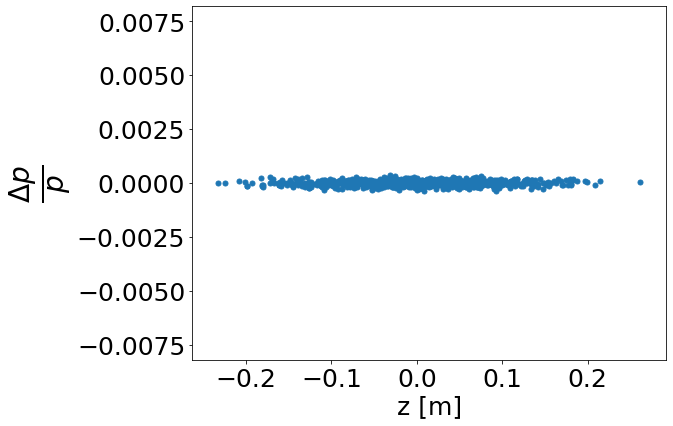

In [241]:
plt.scatter(bunch.z, bunch.delta)
plt.xlabel('z [m]')
plt.ylabel(r'$\frac{\Delta p}{p}$', fontsize = 40)

### Plot longitudinal profile (does this even exist?)

Text(0.5, 1.0, '$\\Delta p /p$')

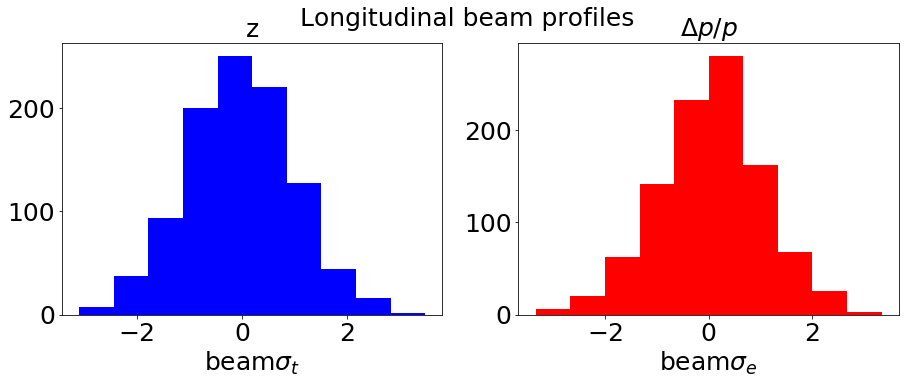

In [242]:
f = plt.figure(figsize=(15,5))
f.suptitle('Longitudinal beam profiles', fontsize = 25)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax.hist(z_initial/sigma_t, color = 'b')
ax.set_xlabel('beam'+r'$\sigma_{t}$')
ax.set_title('z')
ax2.hist(delta_initial/sigma_e, color = 'r')
ax2.set_xlabel('beam'+r'$\sigma_{e}$')
ax2.set_title(r'$\Delta p /p$')

### Initialise data frame to save the turn by turn data

In [243]:
df = pd.DataFrame({'turn':[], 'z':[], 'delta':[], 'y':[], 'py':[]})
# Append the initial values, not normalised
df = df.append({'turn':0, 'z':bunch.x, 'delta':bunch.delta}, ignore_index = True)

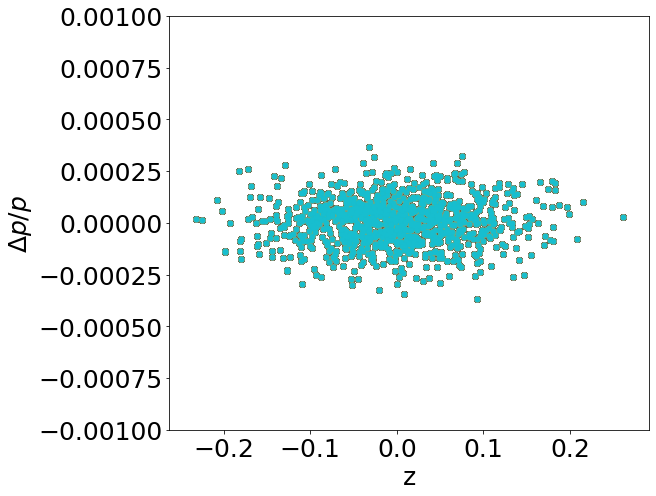

In [248]:
fig, ax = plt.subplots(1,1,figsize=(9,7))



for turn in range(0, 1000): #plot for the first 10 turns
    ax.scatter(bunch.z, bunch.delta)#, label= turn)
    ax.set_xlabel('z')
    ax.set_ylabel(r'$\Delta p /p$')
    bunch.z, bunch.delta =  long_track(dQs, longfrac, bunch.z, bunch.delta)
    #bunch.z,  bunch.delta = drift(eta, alpha_c, L, bunch.z, bunch.delta)
    #bunch.z, bunch.delta = longitudinal_drift_linear(V_rf, T_rev, beta_rel, c, L, P0, eta, h, bunch.z, bunch.delta)
    #plt.legend()
    ax.set_ylim(-1e-3, 1e-3)


plt.tight_layout()